<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/D_VQC_Adhoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer
from IPython.display import clear_output
clear_output()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.5 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512544 sha256=008a450e6727283869bf1338472e861d87d2effda09a1cd5e7080a72d259e53a
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d51

<ipython-input-29-fc513fa99f04>:34: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Training the VQC on ad-hoc data...
Training Accuracy: 61.00%
Test Accuracy: 70.00%


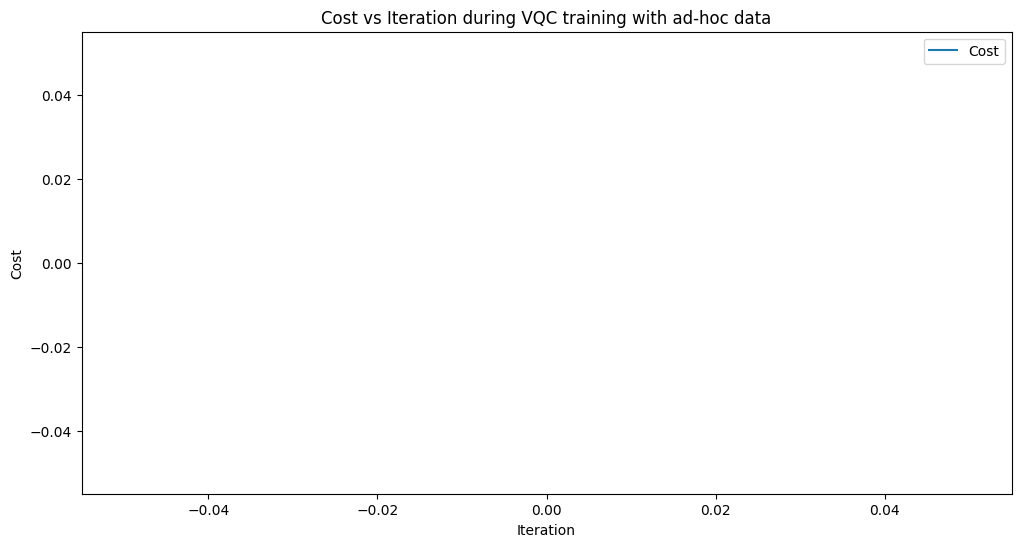

Learning rate data not available for the selected optimizer.


In [29]:
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.utils.loss_functions import Loss
from qiskit_algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit_machine_learning.datasets import ad_hoc_data
# Step 1: Load the ad-hoc dataset
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = ad_hoc_data(
    training_size=50, test_size=15, n=2, gap=0.3, one_hot=False
)

# Rescale the features
scaler = MinMaxScaler()
TRAIN_DATA = scaler.fit_transform(TRAIN_DATA)
TEST_DATA = scaler.transform(TEST_DATA)

# Step 2: Define feature map and ansatz
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
ANSATZ = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Step 3: Define optimizer (SPSA for example)
OPTIMIZER = SPSA(maxiter=60, learning_rate=0.1, perturbation=0.01)

# Step 4: Initialize VQC
sampler = Sampler()
vqc = VQC(
    sampler=sampler,
    feature_map=FEATURE_MAP,
    ansatz=ANSATZ,
    optimizer=OPTIMIZER,
    loss="cross_entropy",  # Using cross-entropy loss
)

# Step 5: Train the VQC model
print("Training the VQC on ad-hoc data...")
vqc.fit(TRAIN_DATA, TRAIN_LABELS)

# Step 6: Test the model
test_predictions = vqc.predict(TEST_DATA)
train_predictions = vqc.predict(TRAIN_DATA)

# Step 7: Evaluate the accuracy
test_accuracy = accuracy_score(TEST_LABELS, test_predictions)
train_accuracy = accuracy_score(TRAIN_LABELS, train_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optional: Plot the results (training cost over iterations)
# Initialize CSV file to log training data (costs)
csv_file = "adhoc_vqc_training_log.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Cost", "LearningRate"])

objective_func_vals = []
learning_rates = []

def callback_graph(weights, obj_func_eval):
    # Clear the previous plot
    clear_output(wait=True)

    objective_func_vals.append(obj_func_eval)

    if isinstance(OPTIMIZER, SPSA):
        learning_rates.append(OPTIMIZER.learning_rate)
    else:
        learning_rates.append(None)

    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([len(objective_func_vals), obj_func_eval, learning_rates[-1]])

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Plot the cost over iterations if the training was logged
data = pd.read_csv(csv_file)

plt.figure(figsize=(12, 6))
plt.plot(data["Iteration"], data["Cost"], label="Cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs Iteration during VQC training with ad-hoc data")
plt.legend()
plt.show()

# Plot the learning rate if available
if not data["LearningRate"].isnull().all():
    plt.figure(figsize=(12, 6))
    plt.plot(data["Iteration"], data["LearningRate"], label="Learning Rate", color='orange')
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate vs Iteration during VQC training with ad-hoc data")
    plt.legend()
    plt.show()
else:
    print("Learning rate data not available for the selected optimizer.")


The follwing code implementation is refer the default qiskit vqc model and it shows environment setting as follows:
1.

Let's try to evaluate different featuremaps, datasets, and optimizers in following code for default qiskit.

# **The following implementation shows how deep unfolding implement in vqc qiskit algorithm**

*   List item
*   List item



<ipython-input-28-9650ae5ff96a>:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


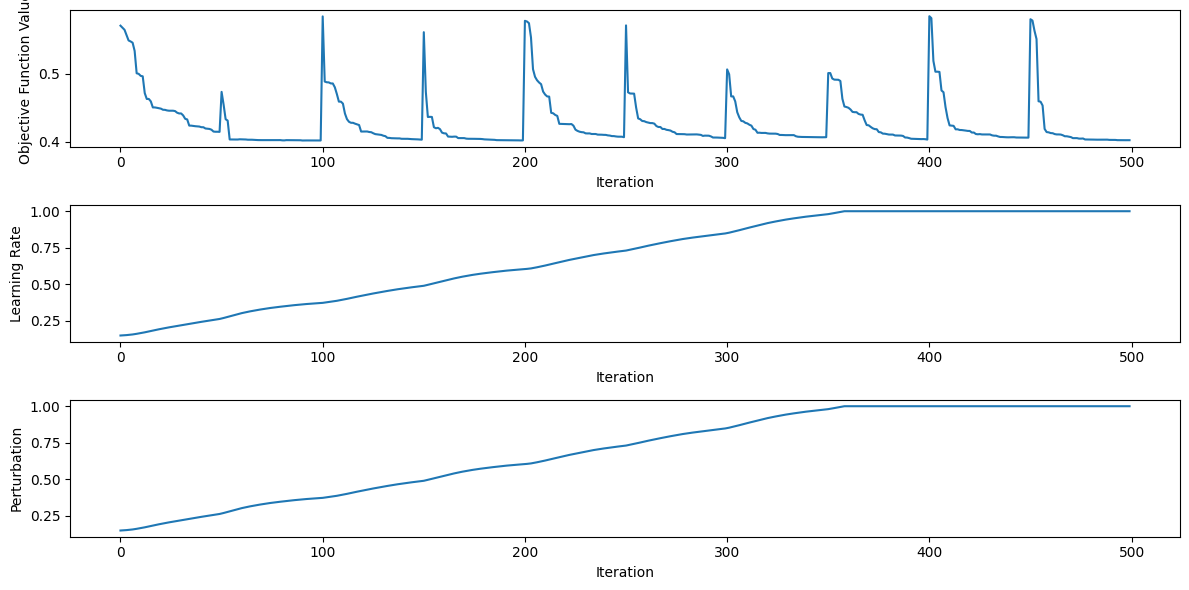

Iteration 10 - Training Accuracy: 100.00%
Iteration 10 - Test Accuracy: 100.00%
Final Training Accuracy: 100.00%
Final Test Accuracy: 100.00%
Total Training Time: 820.59 seconds


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import SPSA
import time
from IPython.display import clear_output
import csv

from qiskit_algorithms.utils import algorithm_globals

# Set random seed for reproducibility
algorithm_globals.random_seed = 42

# Load the ad-hoc dataset
data_train, data_train_labels, data_test, data_test_labels = ad_hoc_data(
    training_size=50, test_size=15, n=2, gap=0.3, one_hot=False
)

# Variables to track objective function, learning rate, and perturbation
objective_func_vals = []
learning_rates = []
perturbations = []
initial_learning_rate = 0.15  # Starting learning rate
initial_perturbation = 0.15  # Starting perturbation value
momentum = 0.95  # Momentum factor for gradient smoothing
gradient_moving_avg_lr = 0
gradient_moving_avg_pert = 0

# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]
feature_map = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

# Callback for visualization and adjustment, matching the number of arguments expected
def deep_unfolding_learning_rate_adjustment(nfev, parameters, obj_func_eval, stepsize=None, accept=None):
    global gradient_moving_avg_lr, gradient_moving_avg_pert, learning_rates, perturbations

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # Apply momentum and update learning rate if gradient is available
    if stepsize is not None:
        gradient_moving_avg_lr = momentum * gradient_moving_avg_lr + (1 - momentum) * stepsize
        delta_lr = 0.05 * gradient_moving_avg_lr
    else:
        delta_lr = 0

    # Apply momentum and update perturbation if gradient is available
    if stepsize is not None:
        gradient_moving_avg_pert = momentum * gradient_moving_avg_pert + (1 - momentum) * stepsize
        delta_perturbation = 0.05 * gradient_moving_avg_pert
    else:
        delta_perturbation = 0

    # Cap learning rate and perturbation updates to avoid runaway values
    max_lr = 1.0  # Maximum allowed learning rate
    max_perturbation = 1.0  # Maximum allowed perturbation

    # Update learning rate and perturbation with caps
    if len(learning_rates) > 0:
        new_lr = max(0.001, min(max_lr, learning_rates[-1] + delta_lr))
        new_perturbation = max(0.001, min(max_perturbation, perturbations[-1] + delta_perturbation))
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    # Visualization of learning rate, perturbation, and objective function
    plt.title("Objective Function, Learning Rate, and Perturbation")

    plt.subplot(3, 1, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(3, 1, 2)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.plot(range(len(learning_rates)), learning_rates)

    plt.subplot(3, 1, 3)
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.plot(range(len(perturbations)), perturbations)

    plt.tight_layout()
    plt.show()

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=0.15, initial_perturbation=0.15, lr_alpha=0.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr
        self.perturbation = initial_perturbation
        self.lr_alpha = lr_alpha

    def _compute_lr_gradient(self, fun, point, grad):
        epsilon_lr = 1e-4  # Small value for finite difference approximation
        lr_plus = self.lr + epsilon_lr
        lr_minus = self.lr - epsilon_lr

        point_plus = point - lr_plus * grad
        point_minus = point - lr_minus * grad

        grad_lr = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_lr)
        return grad_lr

    def _compute_perturbation_gradient(self, fun, point, grad):
        epsilon_pert = 1e-4
        pert_plus = self.perturbation + epsilon_pert
        pert_minus = self.perturbation - epsilon_pert

        point_plus = point - pert_plus * grad
        point_minus = point - pert_minus * grad

        grad_pert = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_pert)
        return grad_pert

    def _update_learning_rate_and_perturbation(self, parameters, obj_func_eval, iteration):
        lr_gradient = self._compute_lr_gradient(self.objective_function, parameters, obj_func_eval)
        pert_gradient = self._compute_perturbation_gradient(self.objective_function, parameters, obj_func_eval)

        # Cap the gradient updates to avoid large changes
        max_grad = 10
        lr_gradient = np.clip(lr_gradient, -max_grad, max_grad)
        pert_gradient = np.clip(pert_gradient, -max_grad, max_grad)

        # Apply meta-learning rate updates
        self.lr += self.lr_alpha * lr_gradient
        self.perturbation += self.lr_alpha * pert_gradient

        # Apply decay and cap to ensure values remain within reasonable range
        decay = 0.99
        self.lr = max(0.001, min(1.0, self.lr * decay))
        self.perturbation = max(0.001, min(1.0, self.perturbation * decay))

    def step(self, gradient, obj_func_eval):
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)

# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
    maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=deep_unfolding_learning_rate_adjustment, lr_alpha=0.01
)

# Initialize VQC model with the deep unfolding optimizer
sampler = Sampler()
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=spsa_optimizer,
    sampler=sampler,
)

# Prepare to save results in a CSV file
csv_file = "vqc_training_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Objective Function Value", "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"])

train_accuracies = []
test_accuracies = []

# Deep Unfolding with multiple iterations
total_time = 0

for i in range(10):
    print(f"Deep Unfolding Iteration {i+1}/10")

    start_time = time.time()
    vqc.fit(data_train, data_train_labels)
    end_time = time.time()
    total_time += end_time - start_time

    final_learning_rate = learning_rates[-1]
    final_perturbation = perturbations[-1]

    train_accuracy = vqc.score(data_train, data_train_labels)
    test_accuracy = vqc.score(data_test, data_test_labels)

    print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")
